In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [150]:
data = pd.read_csv('CGI data.csv')
data.tail()

,date,open,high,low,close,volume
5298,10/28/2019,78.40,78.430,77.91,78.29,127870
5299,10/29/2019,78.25,78.605,77.34,77.38,177438
5300,10/30/2019,77.60,78.150,77.30,78.11,225121
5301,10/31/2019,78.00,78.240,77.59,77.72,177231
5302,11/1/2019,78.00,78.510,77.77,78.31,141106


In [100]:
# converting into time-series data

dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
parse_data = pd.read_csv('CGI data.csv', parse_dates=['date'], 
                         index_col='date',date_parser=dateparse)
parse_data.head()

,open,high,low,close,volume
date,,,,,
1998-10-07,6.125,6.250,6.125,6.220,39200
1998-10-08,6.155,6.155,5.970,6.000,19400
1998-10-09,5.970,5.970,5.250,5.560,88800
1998-10-12,5.625,5.750,5.625,5.625,8800
1998-10-13,5.690,5.690,5.405,5.405,18600


In [101]:
parse_data.shape

(5303, 5)

In [103]:
ts = parse_data['high']
ts.head()

date
1998-10-07    6.250
1998-10-08    6.155
1998-10-09    5.970
1998-10-12    5.750
1998-10-13    5.690
Name: high, dtype: float64

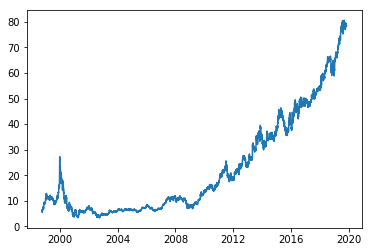

In [109]:
#Plot the data and observe the trend
plt.plot(ts)

##### Statistical Tests for checking stationarity
- Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
- Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [110]:
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test

- To compute moving averages, we have a function called rolling(n).mean() Here, n signifies time-period for moving average. For example, 3-year moving average etc.
- Similarly, we have rolling(n).std() to calculate moving standard deviations.


In [111]:
# Computing 3-month moving average
ts.rolling(3).mean().head()

date
1998-10-07         NaN
1998-10-08         NaN
1998-10-09    6.125000
1998-10-12    5.958333
1998-10-13    5.803333
Name: high, dtype: float64

In [112]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean=timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Note on ADF Test:
- The D-F test and Augmented D-F test is used to check stationarity of time series data. For more details, read:
https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test,
https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test and https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
- The Number of lags or period used for moving average  is taken automatically by the ADF test using the rule: (fourth root of (number of observations/100))*12

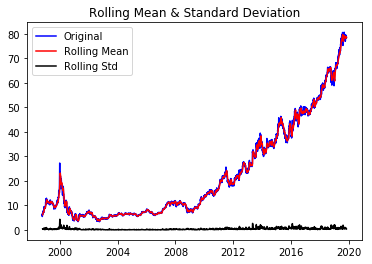

Results of Dickey-Fuller Test:
Test Statistic                    1.974425
p-value                           0.998639
#Lags Used                        7.000000
Number of Observations Used    5295.000000
Critical Value (1%)              -3.431586
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567061
dtype: float64


In [113]:
test_stationarity(ts)

- Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is more than the critical values. Hence we can clearly say that the given time-series data is not stationary.

#### Making time series stationary
- None of the practial time series data are stationary. We need to try to make data stationary as much as possible, for implementation purpose.
- There are 2 major reasons behind non-stationaruty of a TS:
    - Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
    - Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

- The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.
- For this purpose, there are multiple methods.


#### Estimating & Eliminating Trend
##### Method 1: Transformation
- One of the tricks to reduce trend can be transformation. For example, in the current example, we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc.

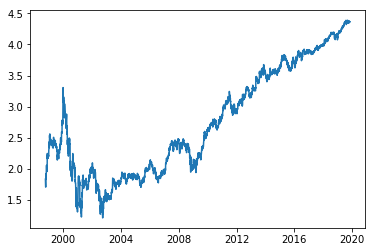

In [114]:
ts_log = np.log(ts)
plt.plot(ts_log)

We can see forward or upward trend here. We need to estimate or model this trend and then remove it from the series. Few methods to do this:
- Aggregation: taking average for a time period like monthly/weekly averages
- Smoothing: taking rolling averages
- Polynomial Fitting: fit a regression model

##### Smoothing using Moving average
Here we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

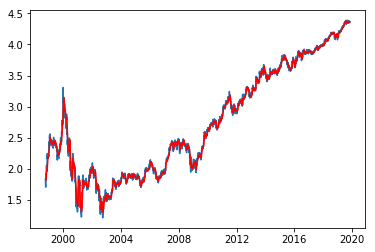

In [115]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [116]:
# Subtract rolling mean from original data
ts_log_moving_avg_diff = ts_log - moving_avg
#ts_log_moving_avg_diff.head(15)

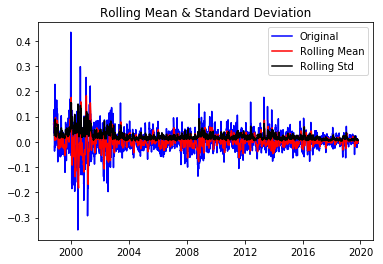

Results of Dickey-Fuller Test:
Test Statistic                -1.289728e+01
p-value                        4.321941e-24
#Lags Used                     3.100000e+01
Number of Observations Used    5.260000e+03
Critical Value (1%)           -3.431594e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


In [117]:
'''
As we took lag as 12, for first 11 values, moving average is not defined. 
So, drop NaN and check the plots to test stationarity.
'''

ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Here, the test-statistic is smaller than 5% critical value. So, with 95% confidence, we can say that this data is stationary. To improve, we can use exponential weighted moving average. 

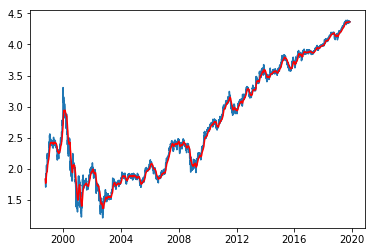

In [118]:
# ewm() is the function used to find exponential weighted moving average
# the parameter ‘halflife’ is used to define the amount of exponential decay.

expwighted_avg= ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

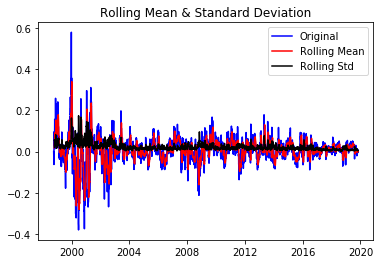

Results of Dickey-Fuller Test:
Test Statistic                -9.932402e+00
p-value                        2.800365e-17
#Lags Used                     3.000000e+01
Number of Observations Used    5.272000e+03
Critical Value (1%)           -3.431591e+00
Critical Value (5%)           -2.862088e+00
Critical Value (10%)          -2.567062e+00
dtype: float64


In [119]:
# Subtract rolling mean from original data

ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

#### Eliminating Trend and Seasonality
- The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:
    - Differencing – taking the differece with a particular time lag
    - Decomposition – modeling both trend and seasonality and removing them from the model.

#### Differencing: 
Here, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas  using shift() function.

In [120]:
ts_log.head()

date
1998-10-07    1.832581
1998-10-08    1.817265
1998-10-09    1.786747
1998-10-12    1.749200
1998-10-13    1.738710
Name: high, dtype: float64

In [121]:
ts_log.shift().head()   #shifted by one

date
1998-10-07         NaN
1998-10-08    1.832581
1998-10-09    1.817265
1998-10-12    1.786747
1998-10-13    1.749200
Name: high, dtype: float64

In [122]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.head()

date
1998-10-07         NaN
1998-10-08   -0.015317
1998-10-09   -0.030518
1998-10-12   -0.037547
1998-10-13   -0.010490
Name: high, dtype: float64

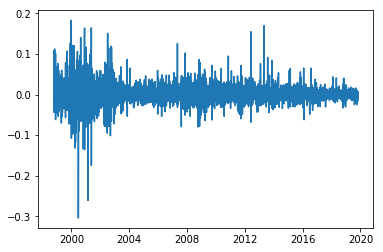

In [123]:
plt.plot(ts_log_diff)

The graph shows that the trend has reduced considerably. Check it using stationarity.

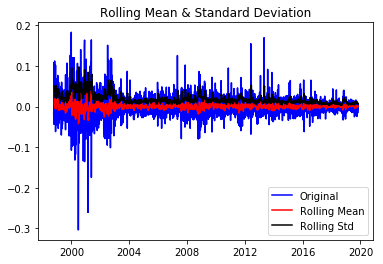

Results of Dickey-Fuller Test:
Test Statistic                -1.387984e+01
p-value                        6.240477e-26
#Lags Used                     3.300000e+01
Number of Observations Used    5.268000e+03
Critical Value (1%)           -3.431592e+00
Critical Value (5%)           -2.862089e+00
Critical Value (10%)          -2.567062e+00
dtype: float64


In [124]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

#### Decomposing:
- Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:
    - Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.
    - Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.
    - Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

- For more details, read: https://anomaly.io/seasonal-trend-decomposition-in-r/ and https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

- Here,  both trend and seasonality are modeled separately and the remaining part of the series is returned.


In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

NameError: name 'trend' is not defined

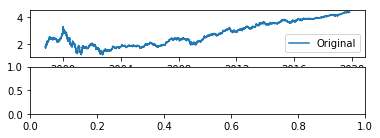

In [44]:
'''
The subplot() takes argument as either a 3-digit integer or three separate 
integers describing the position of the subplot. If the three integers are 
nrows, ncols, and index in order, the subplot will take the index position 
on a grid with nrows rows and ncols columns. index starts at 1 in the upper 
left corner and increases to the right.
'''

plt.subplot(4,1,1)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()  #Automatically adjust subplot parameters to give specified padding.

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Let's check stationarity of residuals.

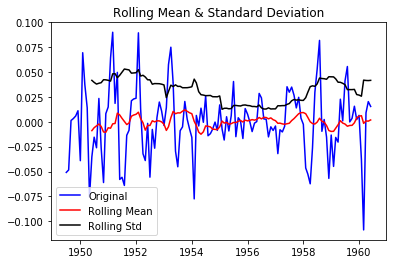

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [31]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. 
One can try advanced decomposition techniques as well which can generate better results.

### Time-series Forecasting
- All the methods used for making the TS data stationary can be used for modeling and prediction.
- But, model on the TS after differencing is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. 
- Having performed the trend and seasonality estimation techniques, there can be two situations:
    - A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
    - A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

### Brief Idea about ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers as below:

    - Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant 't1'... 't2' with series at instant 't1-5' ... 't2-5' (t1-5 and t2 being end points).
    - Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.
The ACF and PACF plots for the TS after differencing can be plotted.

In [125]:
from statsmodels.tsa.stattools import acf, pacf

Text(0.5, 1.0, 'Autocorrelation Function')

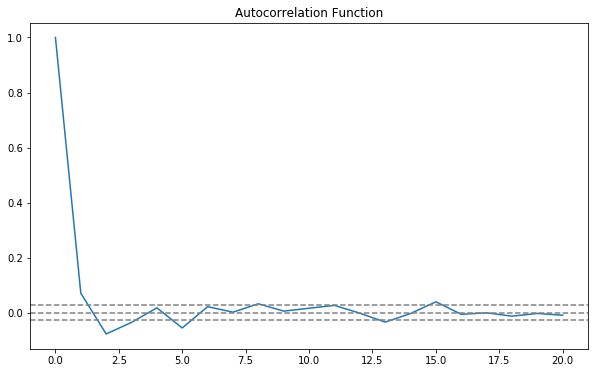

In [126]:
#Plot ACF: 

#plt.subplot(121) 
lag_acf = acf(ts_log_diff, nlags=20)
plt.figure(figsize=(10,6))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')



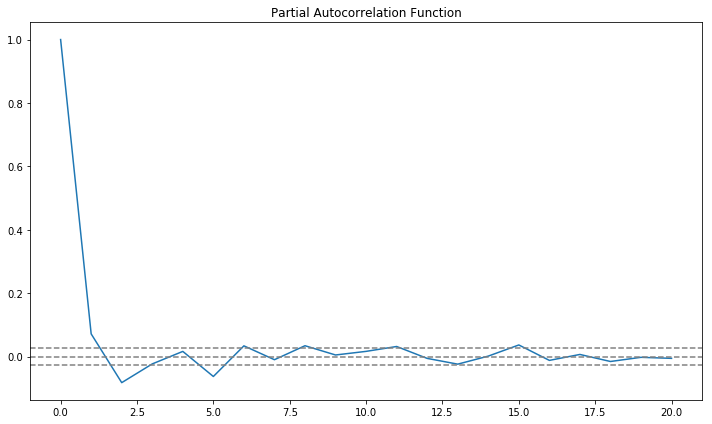

In [127]:
#Plot PACF:
#plt.subplot(122)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
plt.figure(figsize=(10,6))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In these plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

In [128]:
from statsmodels.tsa.arima_model import ARIMA

### AR Model
- The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). 
- For more details, read: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html


In [129]:
# q = 0 means we are doing only AR model

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit()  


C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [130]:
#results_AR.arparams

In [131]:
#results_AR.fittedvalues

Text(0.5, 1.0, 'RSS: 2.8153')

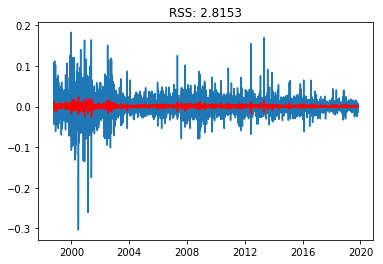

In [132]:
# Compute RSS (Residual Sum of Squares)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

In [133]:
# p is 0 means it is MA model

model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit()  


C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 2.8183')

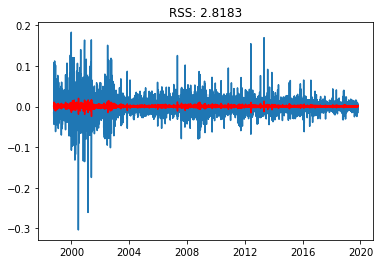

In [134]:
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined Model

C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 2.8139')

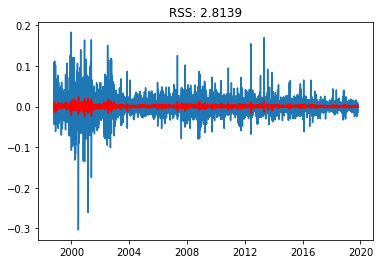

In [135]:
#Both AR and MA are integrated with difference 1

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. 

### Bringing back the original scale of Time Series Data
- Initially, we took log of the TS data and then applied stationarity, ARIMA etc. Now, we have to re-scale it. 


In [136]:
# store the predicted results as a separate series and observe it.
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
1998-10-08    0.000478
1998-10-09   -0.000649
1998-10-12   -0.000620
1998-10-13    0.000448
1998-10-14    0.003518
dtype: float64

Notice that these start from ‘1949-02-01’ and not the first month. This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. 

In [137]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
1998-10-08    0.000478
1998-10-09   -0.000171
1998-10-12   -0.000791
1998-10-13   -0.000342
1998-10-14    0.003176
dtype: float64

Next we have to add them to base number. For this, create a series with all values as base number and add the differences to it.

In [138]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,
                                                  fill_value=0)
predictions_ARIMA_log.head()

date
1998-10-07    1.832581
1998-10-08    1.833060
1998-10-09    1.832411
1998-10-12    1.831791
1998-10-13    1.832239
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

In [139]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA.head()

date
1998-10-07    6.250000
1998-10-08    6.252990
1998-10-09    6.248932
1998-10-12    6.245060
1998-10-13    6.247860
dtype: float64

Text(0.5, 1.0, 'RMSE: 8.0454')

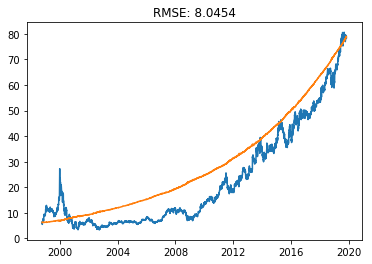

In [140]:
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### Forecasting for future time period

In [156]:
# forecast for 36 months
# note that, we have to use the object on which ARIMA prediction was done
forecast = results_ARIMA.forecast(steps=25)[0]

In [157]:
forecast

array([4.36399925, 4.36428944, 4.36467528, 4.36513616, 4.36561599,
       4.3660963 , 4.36657519, 4.36705353, 4.36753179, 4.36801007,
       4.36848837, 4.36896666, 4.36944496, 4.36992326, 4.37040155,
       4.37087985, 4.37135815, 4.37183644, 4.37231474, 4.37279304,
       4.37327133, 4.37374963, 4.37422792, 4.37470622, 4.37518452])

In [158]:
#convert log values into actuals
forecast_actual=np.exp(forecast)

In [159]:
date_index=pd.date_range(start='11/1/2019', end='11/1/2021',
                         freq= pd.offsets.MonthBegin() )
date_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [160]:
forecast_actual=pd.Series(forecast_actual, index=date_index)
forecast_actual.head()

2019-11-01    78.570731
2019-12-01    78.593535
2020-01-01    78.623865
2020-02-01    78.660110
2020-03-01    78.697862
Freq: MS, dtype: float64

In [161]:
updated_data=ts.append(forecast_actual)

In [162]:
updated_data.tail()

2021-07-01    79.302633
2021-08-01    79.340572
2021-09-01    79.378530
2021-10-01    79.416505
2021-11-01    79.454499
dtype: float64

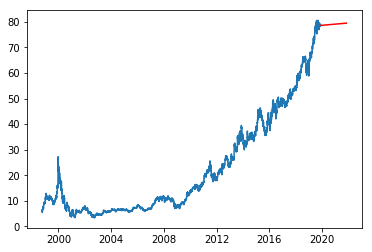

In [163]:
#plt.figure(figsize=(10,6))

plt.plot(updated_data[:'2019'])
plt.plot(updated_data['2019-12-01':], color='red')

In [3]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [5]:
import pandas as pd
df = pd.read_csv('CGI data.csv', parse_dates=['date'],index_col='date')
df.head()

,open,high,low,close,volume
date,,,,,
1998-10-07,6.125,6.250,6.125,6.220,39200
1998-10-08,6.155,6.155,5.970,6.000,19400
1998-10-09,5.970,5.970,5.250,5.560,88800
1998-10-12,5.625,5.750,5.625,5.625,8800
1998-10-13,5.690,5.690,5.405,5.405,18600


c:\users\dell\appdata\local\continuum\anaconda3\envs\tensorflow1\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


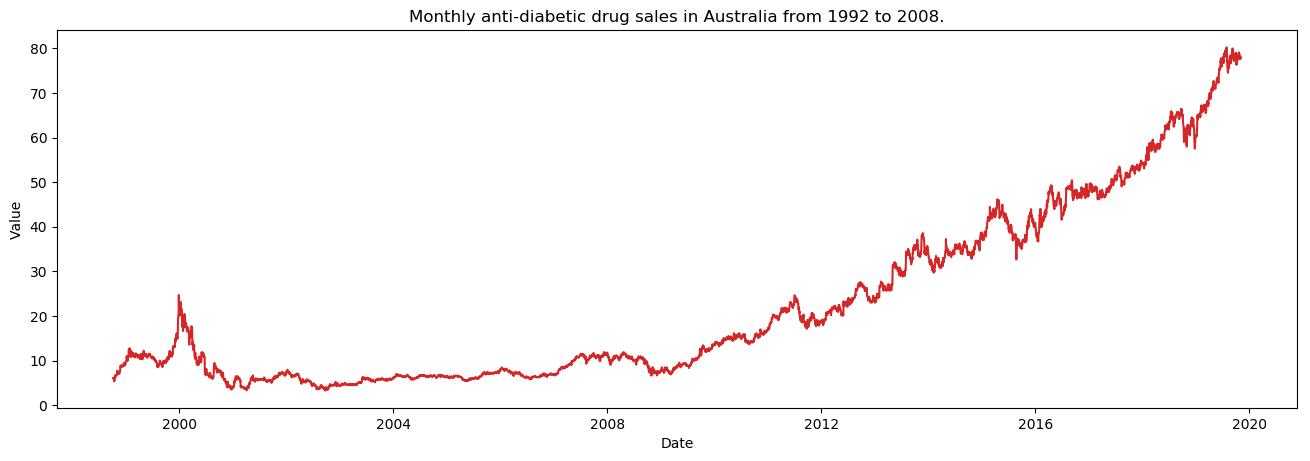

In [6]:
def plot_df(df, x, y, title="plot", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.open, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

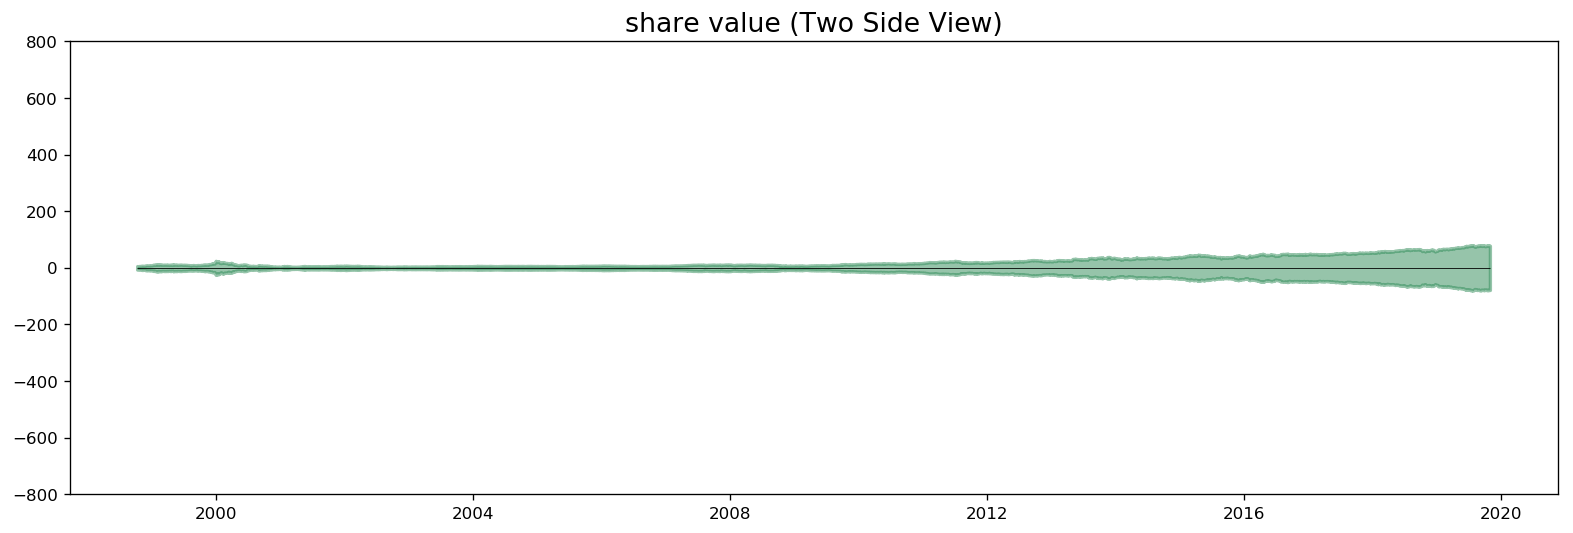

In [9]:
df = pd.read_csv('CGI data.csv', parse_dates=['date'])
x = df['date'].values
y1 = df['open'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('share value (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()

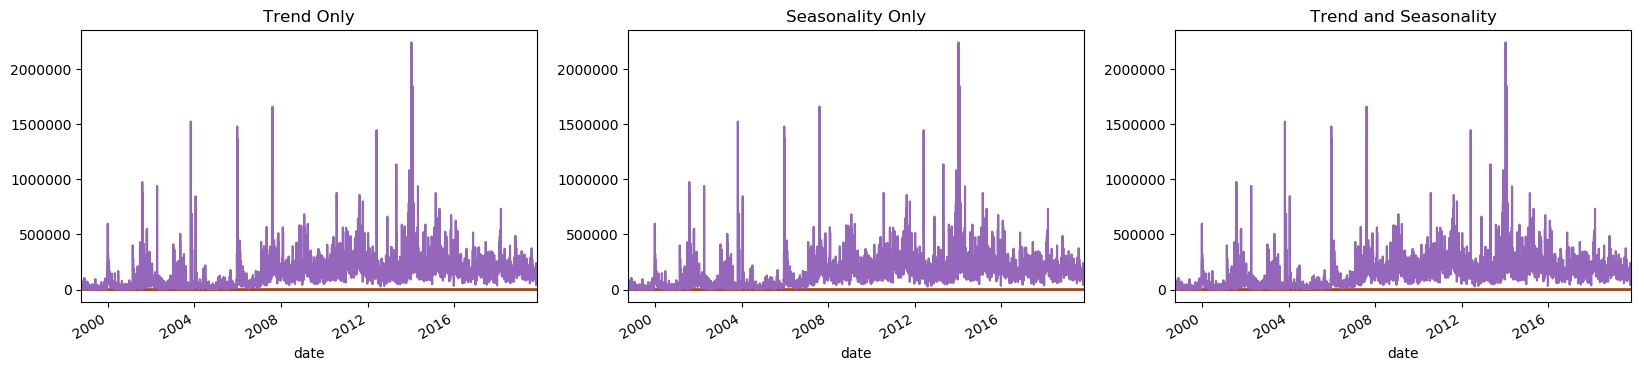

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)

pd.read_csv('CGI data.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('CGI data.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('CGI data.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])